In [25]:
import networkx as nx
import pandas as pd
from dowhy import gcm
import numpy as np
import matplotlib.pyplot as plt

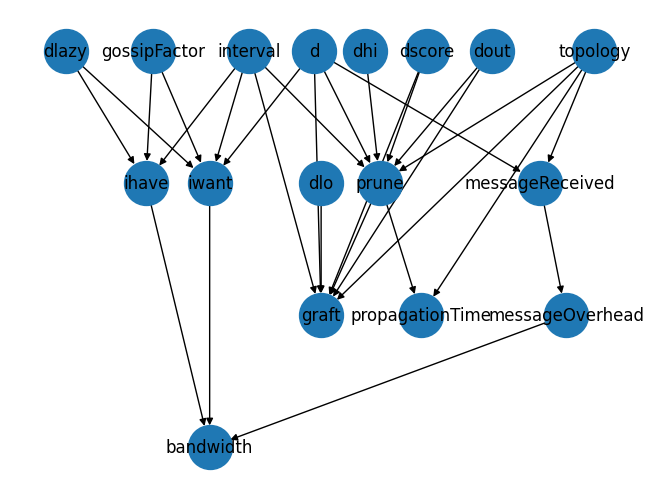

In [32]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('iwant', 'bandwidth'),
                           ('ihave', 'bandwidth')
                         ])
pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

In [6]:
#Import data 
data = pd.read_csv('../Notebooks/datasets/timeSeries1_verified.csv',header=0, index_col=0)
df = pd.DataFrame(data)

df.head(10)

,identifier,experiment,type,_time,count
0,0,391.0,2.0,2023-10-04 19:25:30+00:00,1574
1,0,391.0,2.0,2023-10-04 19:25:40+00:00,6412
2,0,391.0,2.0,2023-10-04 19:25:50+00:00,4602
3,0,391.0,2.0,2023-10-04 19:26:00+00:00,4605
4,0,391.0,2.0,2023-10-04 19:26:10+00:00,6171
5,0,391.0,2.0,2023-10-04 19:26:20+00:00,4642
6,0,391.0,2.0,2023-10-04 19:26:30+00:00,4643
7,0,391.0,2.0,2023-10-04 19:26:40+00:00,6142
8,0,391.0,2.0,2023-10-04 19:26:50+00:00,5016
9,0,391.0,2.0,2023-10-04 19:27:00+00:00,4996


In [7]:
# Transpose the table -> type and count

df['_time'] = pd.to_datetime(df["_time"], format='mixed', infer_datetime_format=True)
by_time = df.groupby([df['experiment'],df['identifier'],df['type'],pd.Grouper(key="_time", freq='1s')])['count'].sum().reset_index()
# by_time.head(10)
pivoted = pd.pivot_table(by_time,index=["identifier","experiment", pd.Grouper(freq="10s", key="_time")], columns="type", values="count", margins=False).fillna(0)
pivoted = pivoted.reset_index().rename_axis(None, axis=1)

pivoted.head(100)

/tmp/ipykernel_39063/1443210762.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['_time'] = pd.to_datetime(df["_time"], format='mixed', infer_datetime_format=True)


,identifier,experiment,_time,2.0,3.0,11.0,12.0,16.0,17.0
0,0,391.0,2023-10-04 19:25:30+00:00,1574.0,192.0,0.0,0.0,0.0,109.0
1,0,391.0,2023-10-04 19:25:40+00:00,6412.0,795.0,0.0,0.0,0.0,395.0
2,0,391.0,2023-10-04 19:25:50+00:00,4602.0,576.0,0.0,0.0,1.0,361.0
3,0,391.0,2023-10-04 19:26:00+00:00,4605.0,575.0,0.0,0.0,0.0,325.0
4,0,391.0,2023-10-04 19:26:10+00:00,6171.0,767.0,0.0,0.0,0.0,387.0
...,...,...,...,...,...,...,...,...,...
95,0,391.0,2023-10-04 19:44:50+00:00,19744.0,2935.0,0.0,0.0,0.0,1142.0
96,0,391.0,2023-10-04 19:45:00+00:00,15108.0,2238.0,0.0,0.0,0.0,987.0
97,0,391.0,2023-10-04 19:45:10+00:00,14310.0,2111.0,0.0,0.0,0.0,1136.0
98,0,391.0,2023-10-04 19:45:20+00:00,19631.0,2898.0,0.0,0.0,0.0,1029.0


In [8]:
#Rename
eventsTS = pivoted.rename(columns={2.0:'messageReceived', 3.0: 'messageDuplicated', 11.0: 'graft', 12.0: 'prune', 16.0: 'iwant', 17.0:'ihave'})
eventsTS.head(500)

,identifier,experiment,_time,messageReceived,messageDuplicated,graft,prune,iwant,ihave
0,0,391.0,2023-10-04 19:25:30+00:00,1574.0,192.0,0.0,0.0,0.0,109.0
1,0,391.0,2023-10-04 19:25:40+00:00,6412.0,795.0,0.0,0.0,0.0,395.0
2,0,391.0,2023-10-04 19:25:50+00:00,4602.0,576.0,0.0,0.0,1.0,361.0
3,0,391.0,2023-10-04 19:26:00+00:00,4605.0,575.0,0.0,0.0,0.0,325.0
4,0,391.0,2023-10-04 19:26:10+00:00,6171.0,767.0,0.0,0.0,0.0,387.0
...,...,...,...,...,...,...,...,...,...
495,12,404.0,2023-10-05 02:44:50+00:00,1074.0,250.0,0.0,0.0,0.0,220.0
496,12,404.0,2023-10-05 02:45:00+00:00,1259.0,288.0,0.0,0.0,0.0,213.0
497,12,404.0,2023-10-05 02:45:10+00:00,1055.0,241.0,0.0,0.0,0.0,214.0
498,12,404.0,2023-10-05 02:45:20+00:00,1005.0,231.0,0.0,0.0,0.0,212.0


In [9]:
#Group events by experiment
gb = eventsTS.drop(columns=['_time'])
groupby = gb.groupby(['identifier','experiment']).agg(["sum"]).sort_values(by=["identifier", "experiment"])
groupby.columns = groupby.columns.droplevel(1)
groupby = groupby.reset_index().rename_axis(None, axis=1)

groupby.head(100)

,identifier,experiment,messageReceived,messageDuplicated,graft,prune,iwant,ihave
0,0,391.0,1681977.0,242460.0,1537.0,125.0,17.0,109756.0
1,3,394.0,1843504.0,164486.0,2137.0,0.0,1.0,4868.0
2,6,397.0,1428254.0,124371.0,2138.0,0.0,0.0,792.0
3,12,404.0,762906.0,156136.0,1387.0,135.0,12.0,71454.0
4,13,406.0,1778309.0,351875.0,1469.0,308.0,46.0,141786.0
5,18,413.0,870750.0,151214.0,2136.0,0.0,2.0,4869.0
6,21,416.0,1998816.0,205431.0,2134.0,0.0,0.0,9774.0
7,23,419.0,2013329.0,198723.0,1819.0,0.0,14.0,8629.0
8,27,421.0,1957411.0,217007.0,2138.0,0.0,1.0,9194.0
9,29,425.0,1008492.0,108908.0,1777.0,14.0,23.0,185785.0


In [10]:
#Group events by identifier
gb = groupby.drop(columns='experiment')
events = gb.groupby(['identifier']).agg(["mean"]).sort_values(by=["identifier"])

events.columns = events.columns.droplevel(1)
events = events.reset_index().rename_axis(None, axis=1)

events.head(100)

,identifier,messageReceived,messageDuplicated,graft,prune,iwant,ihave
0,0,1681977.0,242460.0,1537.0,125.0,17.0,109756.0
1,3,1843504.0,164486.0,2137.0,0.0,1.0,4868.0
2,6,1428254.0,124371.0,2138.0,0.0,0.0,792.0
3,12,762906.0,156136.0,1387.0,135.0,12.0,71454.0
4,13,1778309.0,351875.0,1469.0,308.0,46.0,141786.0
5,18,870750.0,151214.0,2136.0,0.0,2.0,4869.0
6,21,1998816.0,205431.0,2134.0,0.0,0.0,9774.0
7,23,2013329.0,198723.0,1819.0,0.0,14.0,8629.0
8,27,1957411.0,217007.0,2138.0,0.0,1.0,9194.0
9,29,1008492.0,108908.0,1777.0,14.0,23.0,185785.0


In [167]:
#Import consolidated measurement data

data = pd.read_csv('../Notebooks/datasets/bandwidth.csv',header=0, index_col=0)
df2 = pd.DataFrame(data)

df2 = df2.drop(columns=['Unnamed: 19', 'stddev_propagationTime', 'stddev_messageOverhead', 'stddev_bandwidth'])


df2.head(10)

,identifier,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,n_nodes,consensus,propagationTime,messageOverhead,bandwidth
0,0,unl,8,6,12,4,8,2,0.25,1.0,24,3.022872,2149.216025,1262081.5,1830.489559
1,3,unl,8,6,12,4,8,2,0.25,3.0,24,3.026471,2160.133107,1220458.0,1606.169639
2,6,unl,16,8,20,16,8,4,0.50,1.0,24,3.027537,2008.636699,991947.5,1299.755180
3,12,unl,16,8,20,16,8,4,0.50,0.5,24,3.073917,6674.953667,388920.0,621.536311
4,13,unl,6,4,8,2,2,2,0.25,1.0,24,3.038808,3089.497825,859426.5,1362.596343
5,18,unl,6,4,8,2,2,4,0.25,0.5,24,3.014395,2097.297225,391164.5,592.199166
6,21,unl,20,16,24,8,16,8,0.50,1.0,24,3.029904,2013.597379,1063446.0,1429.535814
7,23,unl,16,8,20,4,8,2,0.50,1.0,24,3.021019,2353.420496,1347907.5,1784.607281
8,27,unl,16,8,20,8,8,4,0.25,1.0,24,3.025704,1903.031597,952511.0,1281.485378
9,29,unl,16,8,20,4,8,2,0.25,1.0,24,3.044116,1963.333217,809796.5,1166.508678


In [168]:
# Merge events and measured data
consolidated = df2.merge(events, on='identifier')
# consolidated = consolidated.set_index('identifier')

consolidated.head(100)

,identifier,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,...,consensus,propagationTime,messageOverhead,bandwidth,messageReceived,messageDuplicated,graft,prune,iwant,ihave
0,0,unl,8,6,12,4,8,2,0.25,1.00,...,3.022872,2149.216025,1262081.5,1830.489559,1681977.0,242460.0,1537.0,125.0,17.0,109756.0
1,3,unl,8,6,12,4,8,2,0.25,3.00,...,3.026471,2160.133107,1220458.0,1606.169639,1843504.0,164486.0,2137.0,0.0,1.0,4868.0
2,6,unl,16,8,20,16,8,4,0.50,1.00,...,3.027537,2008.636699,991947.5,1299.755180,1428254.0,124371.0,2138.0,0.0,0.0,792.0
3,12,unl,16,8,20,16,8,4,0.50,0.50,...,3.073917,6674.953667,388920.0,621.536311,762906.0,156136.0,1387.0,135.0,12.0,71454.0
4,13,unl,6,4,8,2,2,2,0.25,1.00,...,3.038808,3089.497825,859426.5,1362.596343,1778309.0,351875.0,1469.0,308.0,46.0,141786.0
5,18,unl,6,4,8,2,2,4,0.25,0.50,...,3.014395,2097.297225,391164.5,592.199166,870750.0,151214.0,2136.0,0.0,2.0,4869.0
6,21,unl,20,16,24,8,16,8,0.50,1.00,...,3.029904,2013.597379,1063446.0,1429.535814,1998816.0,205431.0,2134.0,0.0,0.0,9774.0
7,23,unl,16,8,20,4,8,2,0.50,1.00,...,3.021019,2353.420496,1347907.5,1784.607281,2013329.0,198723.0,1819.0,0.0,14.0,8629.0
8,27,unl,16,8,20,8,8,4,0.25,1.00,...,3.025704,1903.031597,952511.0,1281.485378,1957411.0,217007.0,2138.0,0.0,1.0,9194.0
9,29,unl,16,8,20,4,8,2,0.25,1.00,...,3.044116,1963.333217,809796.5,1166.508678,1008492.0,108908.0,1777.0,14.0,23.0,185785.0


In [169]:
# Create the structural causal model object
scm = gcm.StructuralCausalModel(causal_graph)

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm, consolidated)

In [170]:
#Fit model to data
gcm.fit(scm, consolidated)

Fitting causal mechanism of node bandwidth: 100%|██████████| 17/17 [00:00<00:00, 59.76it/s]      


In [ ]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}


arrow_strengths = gcm.arrow_strength(scm, target_node='bandwidth')

gcm.util.plot(causal_graph, causal_strengths=convert_to_percentage(arrow_strengths))#, figure_size=[15, 10])

Estimating Shapley Values. Average change of Shapley values in run 3 (15 evaluated permutations): -2.6302084213614507%: 100%|██████████| 1/1 [00:25<00:00, 25.22s/it]


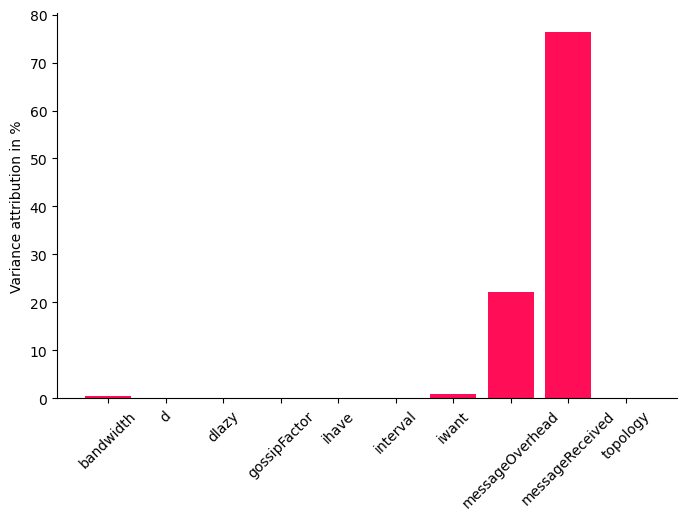

In [172]:
def bar_plot(value_dictionary, ylabel, uncertainty_attribs=None, figsize=(8, 5)):
    value_dictionary = {k: value_dictionary[k] for k in sorted(value_dictionary)}
    if uncertainty_attribs is None:
        uncertainty_attribs = {node: [value_dictionary[node], value_dictionary[node]] for node in value_dictionary}

    _, ax = plt.subplots(figsize=figsize)
    ci_plus = [uncertainty_attribs[node][1] - value_dictionary[node] for node in value_dictionary.keys()]
    ci_minus = [value_dictionary[node] - uncertainty_attribs[node][0] for node in value_dictionary.keys()]
    yerr = np.array([ci_minus, ci_plus])
    yerr[abs(yerr) < 10**-7] = 0
    plt.bar(value_dictionary.keys(), value_dictionary.values(), yerr=yerr, ecolor='#1E88E5', color='#ff0d57', width=0.8)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.show()


iccs = gcm.intrinsic_causal_influence(scm, target_node='bandwidth', num_samples_randomization=500)

bar_plot(convert_to_percentage(iccs), ylabel='Variance attribution in %')

<AxesSubplot:>

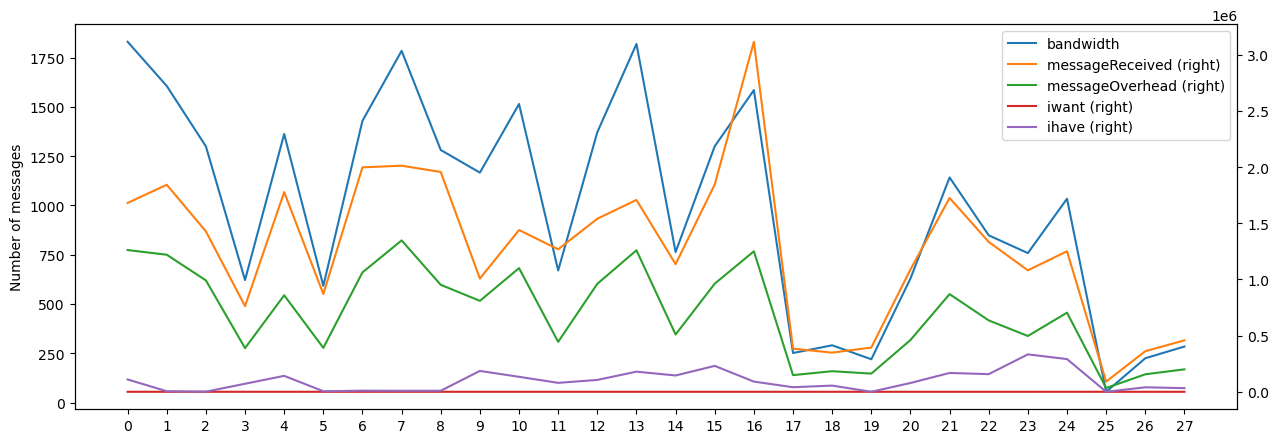

In [193]:
fig, ax = plt.subplots(figsize=(15,5)) 

ax = consolidated.plot(y='bandwidth', ylabel='Bandwidth in messages/s', rot=45, xticks=consolidated.index, ax=ax)
consolidated.plot(y='messageReceived', ax=ax, secondary_y = True, ylabel='Number of messages')

consolidated.plot(y = 'messageOverhead', ax=ax, secondary_y = True)
consolidated.plot(y = 'iwant', ax=ax, secondary_y = True)
consolidated.plot(y='ihave', ax=ax, secondary_y = True)


In [162]:
attributions = gcm.attribute_anomalies(scm, target_node='bandwidth', anomaly_samples=first_day_2022)

bar_plot({k: v[0] for k, v in attributions.items()}, ylabel='Anomaly attribution score')


NameError: name 'first_day_2022' is not defined